In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

## Data Merge

#### Load data

In [2]:
# path to all csv files
paths = []
for root, dirs, files in os.walk("D:/Julie/develop/oil/data"):
    for f in files:
        paths.append(os.path.join(root, f))

In [3]:
# 各別合併P2, P3, P4資料夾中的csv
df2, df3, df4 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for path in paths:
    df = pd.read_csv(path)

    if "P2" in path:
        df2 = pd.concat([df2, df], ignore_index = True)
    elif "P3" in path:
        df.columns = ['桃儲批號', '麥寮批號', '麥寮', '桃儲', '停泵日期', '取樣時間', '檢驗完成時間', '靜置H', '導電度', '溫度℃', '密度ｋｇ／ｍ３']#有些檔案的'密度ｋｇ／ｍ３'加了"\n"，需統一
        df3        = pd.concat([df3, df], ignore_index = True)
    elif "P4" in path:
        df4 = pd.concat([df4, df], ignore_index = True)
print(len(df2), len(df3), len(df4))

373 488 296


#### Outlier

##### P2

In [4]:
df2.head(3)

,輸油批號編號,麥寮廠油槽槽號,桃儲站油槽槽號,起泵時間,停泵時間,油量增加比例,start_vol,end_vol,壓力Kg/cm2,管線溫度℃,即時流速(KL/HR),EC_0,EC_1,EC_2,EC_3,EC_4,EC_5,EC_6,EC_7
0,20201102-02-JFI-ML-TU,T-8513,T-A403,2020-11-02 21:19:00,2020-11-03 17:38:00,3.820285,1742.663,6657.470,2.460500,27.572727,223.029545,368.0,363.0,360.0,NaN,NaN,NaN,NaN,NaN
1,20201104-02-JFI-ML-TU,T-8513,T-A404,2020-11-04 20:56:00,2020-11-05 16:05:00,3.116438,1860.085,5796.840,2.664364,27.488636,220.152273,360.0,374.0,374.0,389.0,355.0,330.0,NaN,NaN
2,20201106-01-JFI-ML-TU,T-8513,T-A401,2020-11-06 02:18:00,2020-11-06 22:19:00,2.255220,1601.625,3612.017,3.877000,26.432143,180.342857,345.0,349.0,360.0,341.0,350.0,345.0,350.0,NaN


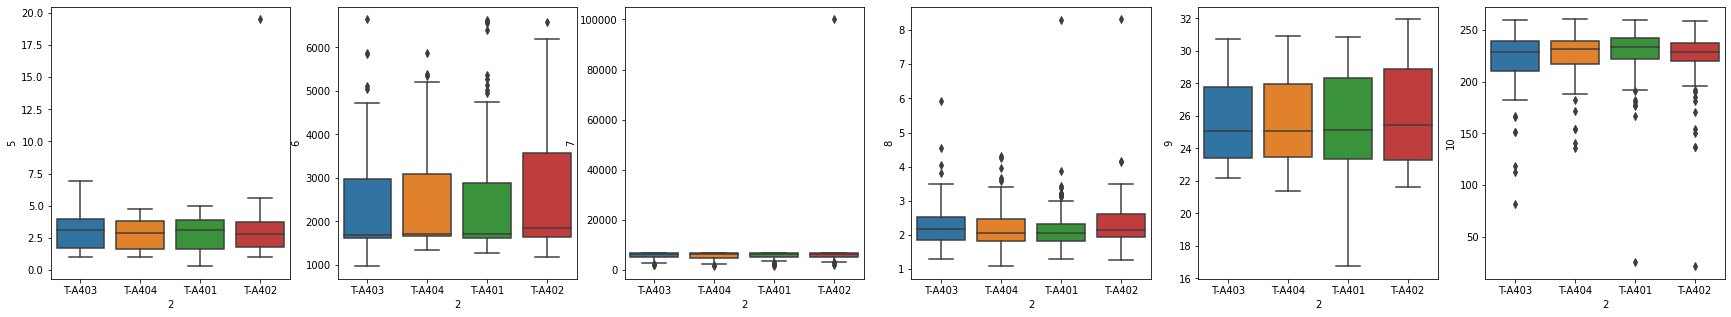

In [5]:
# '油量增加比例', 'start_vol', 'end_vol', '壓力Kg/cm2', '管線溫度℃'
col = df2.columns
df2.columns = list(range(df2.shape[1]))
fig, ax = plt.subplots(1, 6, figsize = (30, 5))
k = 5
for i in range(6):
    sns.boxplot(x = 2, y = df2.columns[k], data = df2, ax = ax[i])
    k += 1
df2.columns = col

In [6]:
# 油量最多只到7000，end_vol有個key錯
df2.iloc[200, 7] = 7000

In [7]:
# 刪除P2 outlier，油量後面再處理
column = ["油量增加比例", '壓力Kg/cm2', '即時流速(KL/HR)']
for c in column:
    category = df2["桃儲站油槽槽號"].unique()
    for i in category:
        g    = df2.groupby("桃儲站油槽槽號")
        df   = g.get_group(i).copy()
        Q1   = df[c].quantile(0.25)
        Q3   = df[c].quantile(0.75)
        IQR  = Q3 - Q1
        min_ = Q1 - (1.5 * IQR)
        max_ = Q3 + (1.5 * IQR)
        
        df[c] = df[c].apply(lambda X: max_ if X > max_ else X)
        df[c] = df[c].apply(lambda X: min_ if X < min_ else X)
        df2.update(df)

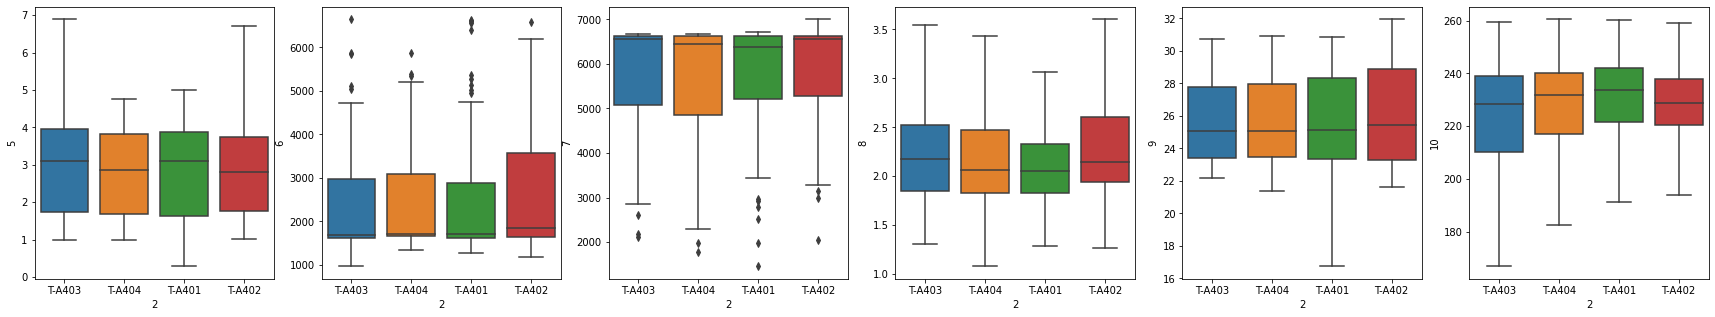

In [8]:
col = df2.columns
df2.columns = list(range(df2.shape[1]))
fig, ax = plt.subplots(1, 6, figsize = (30, 5))
k = 5
for i in range(6):
    sns.boxplot(x = 2, y = df2.columns[k], data = df2, ax = ax[i])
    k += 1
df2.columns = col

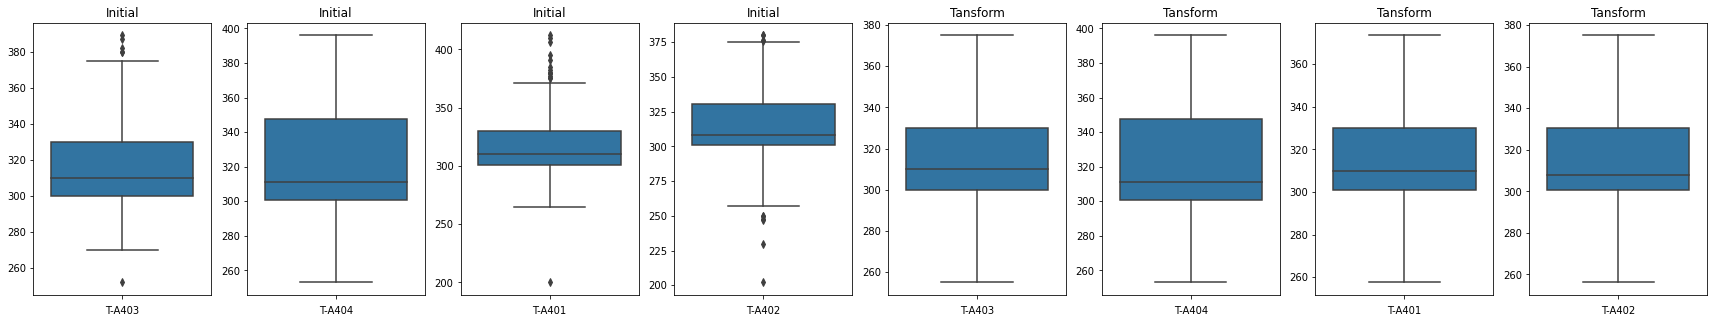

In [9]:
# 刪除P2_EC的outlier，0~7期的所有EC一起算
k   = 0
col = df2.columns[-8:]
fig, ax  = plt.subplots(1, 8, figsize = (30, 5))
category = df2["桃儲站油槽槽號"].unique()
for i in category:
    g  = df2.groupby("桃儲站油槽槽號")
    df = g.get_group(i).copy()
    EC = df[col].values.reshape(-1) #轉成一維
    EC = [j for j in EC if not np.isnan(j)] #刪除nan

    Q1   = np.quantile(EC, 0.25)
    Q3   = np.quantile(EC, 0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)

    df[col] = df[col].applymap(lambda X: max_ if X > max_ else X)
    df[col] = df[col].applymap(lambda X: min_ if X < min_ else X)
    df2.update(df)

    EC1 = df[col].values.reshape(-1)
    EC1 = [j for j in EC1 if not np.isnan(j)]
    
    sns.boxplot(y = EC, ax = ax[k]).set(xlabel = f"{i}", title = 'Initial')
    sns.boxplot(y = EC1, ax = ax[k+4]).set(xlabel = f"{i}", title = 'Tansform')
    k += 1

##### P3

In [10]:
df3.head(3)

,桃儲批號,麥寮批號,麥寮,桃儲,停泵日期,取樣時間,檢驗完成時間,靜置H,導電度,溫度℃,密度ｋｇ／ｍ３
0,T-A401-0715,JF-512-09B2,T-8512,T-A401,2019-11-16,2019-11-18 05:00:00,2019-11-18 06:00:00,24,209,26.5,787.3
1,T-A401-0716,JF-512-09B2,T-8512,T-A401,2019-11-20,2019-11-22 05:30:00,2019-11-22 06:30:00,36,200,25.0,787.3
2,T-A401-0717,JF-514-09B3,T-8514,T-A401,2019-11-25,2019-11-26 06:00:00,2019-11-26 07:00:00,25,215,24.9,786.0


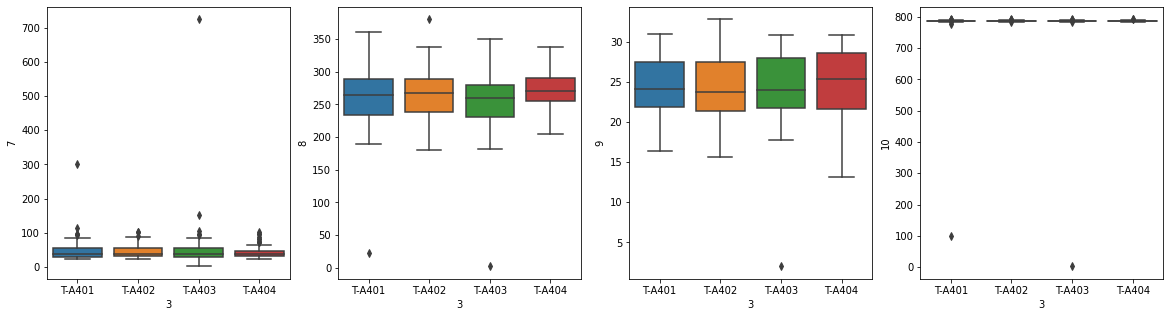

In [11]:
# '靜置H', '導電度', '溫度℃', '密度ｋｇ／ｍ３'
col = df3.columns
df3.columns = list(range(df3.shape[1]))
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
k = 7
for i in range(4):
    sns.boxplot(x = 3, y = df3.columns[k], data = df3, ax = ax[i])
    k += 1
df3.columns = col

In [12]:
# 刪除P3 outlier
for c in col[7:]:
    category = df3["桃儲"].unique()
    for i in category:
        g    = df3.groupby("桃儲")
        df   = g.get_group(i).copy()
        Q1   = df[c].quantile(0.25)
        Q3   = df[c].quantile(0.75)
        IQR  = Q3 - Q1
        min_ = Q1 - (1.5 * IQR)
        max_ = Q3 + (1.5 * IQR)
        
        df[c] = df[c].apply(lambda X: max_ if X > max_ else X)
        df[c] = df[c].apply(lambda X: min_ if X < min_ else X)
        df3.update(df)

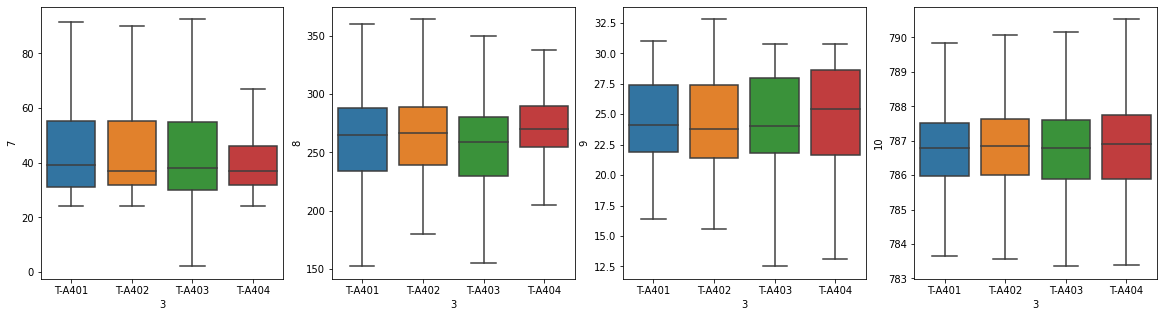

In [13]:
col = df3.columns
df3.columns = list(range(df3.shape[1]))
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
k = 7
for i in range(4):
    sns.boxplot(x = 3, y = df3.columns[k], data = df3, ax = ax[i])
    k += 1
df3.columns = col

##### P4

In [14]:
df4.head(3)

,輸油批號編號,桃儲站油槽槽號,桃園機場油槽槽號,起泵時間,停泵時間,start_vol,end_vol,油溫℃,管線壓力Kg/cm2,管線溫度℃,...,input_管線壓力Kg/cm2,input_管線溫度℃,EC_0,EC_1,EC_2,EC_3,EC_4,EC_5,EC_6,EC_7
0,20201102-01-JFI-TU-TUA,T-A404,T-K701,2020-11-02 17:30:03,2020/11/03 11:11,6612.219,1856.369,25.483333,9.023833,29.029167,...,3.631111,26.458333,270.0,260.0,276.0,270.0,NaN,NaN,NaN,NaN
1,20201104-01-JFI-TU-TUA,T-A401,T-K703,2020-11-04 17:04:27,2020/11/05 12:30,6626.279,3007.891,25.126316,8.881263,28.521053,...,3.616316,26.222368,287.0,286.0,290.0,290.0,290.0,NaN,NaN,NaN
2,20201105-01-JFI-TU-TUA,T-A402,T-K702,2020-11-05 16:44:00,2020/11/06 10:17,6640.853,4418.211,26.300000,8.945857,28.830357,...,3.532857,26.255357,301.0,295.0,275.0,298.0,360.0,NaN,NaN,NaN


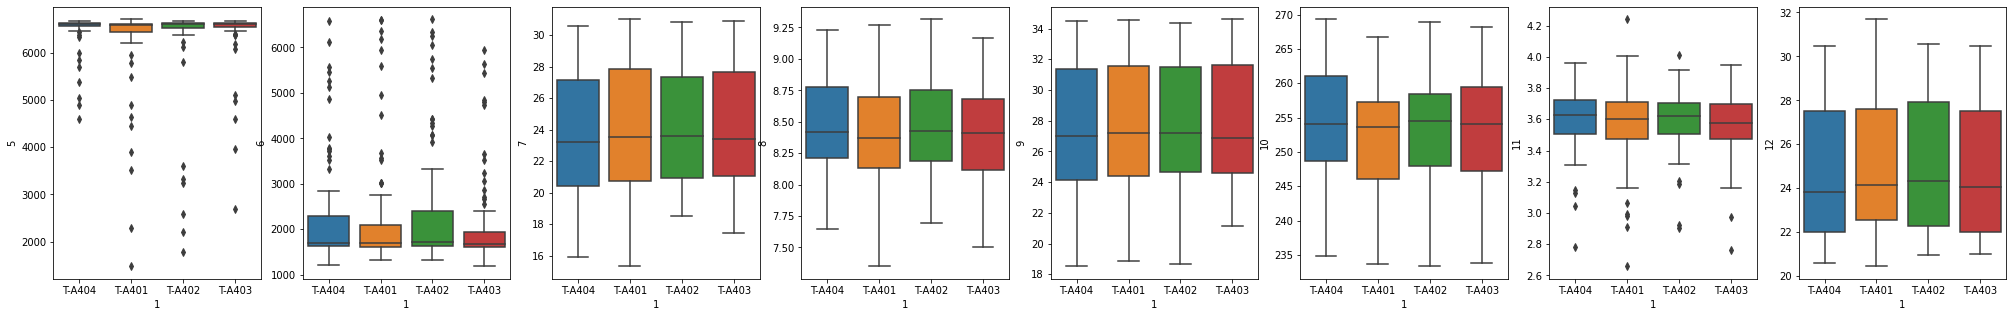

In [15]:
# 'start_vol', 'end_vol', '油溫℃', '管線壓力Kg/cm2', '管線溫度℃', '即時流速(KL/HR)', 'input_管線壓力Kg/cm2', 'input_管線溫度℃'
col = df4.columns
df4.columns = list(range(df4.shape[1]))
fig, ax = plt.subplots(1, 8, figsize = (35, 5))
k = 5
for i in range(8):
    sns.boxplot(x = 1, y = df4.columns[k], data = df4, ax = ax[i])
    k += 1
df4.columns = col

In [16]:
# 刪除P4 outlier
for c in ["input_管線壓力Kg/cm2"]:
    category = df4["桃儲站油槽槽號"].unique()
    for i in category:
        g    = df4.groupby("桃儲站油槽槽號")
        df   = g.get_group(i).copy()
        Q1   = df[c].quantile(0.25)
        Q3   = df[c].quantile(0.75)
        IQR  = Q3 - Q1
        min_ = Q1 - (1.5 * IQR)
        max_ = Q3 + (1.5 * IQR)
        
        df[c] = df[c].apply(lambda X: max_ if X > max_ else X)
        df[c] = df[c].apply(lambda X: min_ if X < min_ else X)
        df4.update(df)

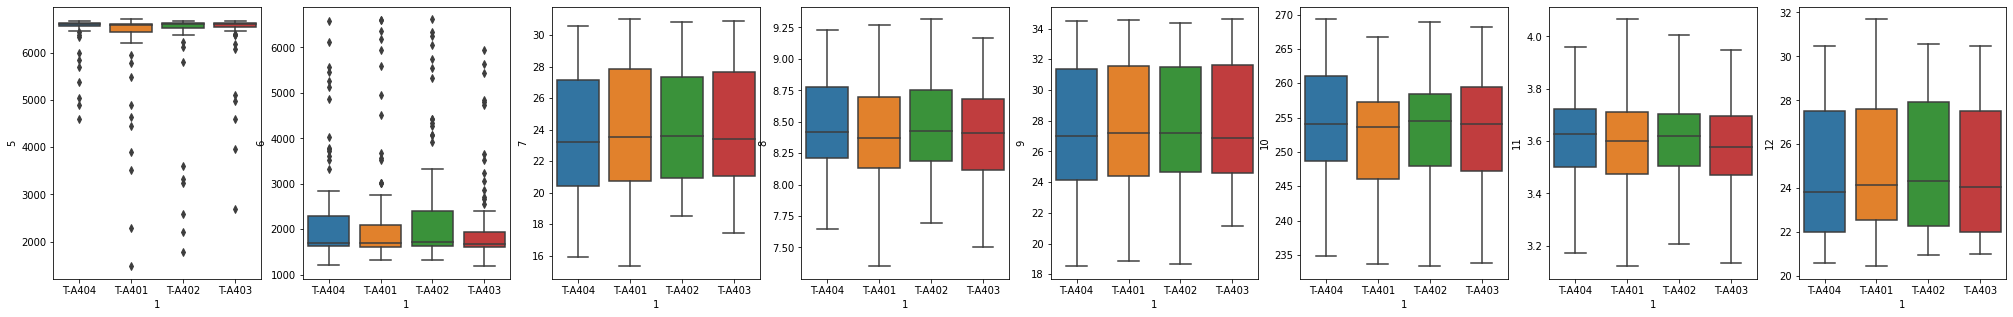

In [17]:
col = df4.columns
df4.columns = list(range(df4.shape[1]))
fig, ax = plt.subplots(1, 8, figsize = (35, 5))
k = 5
for i in range(8):
    sns.boxplot(x = 1, y = df4.columns[k], data = df4, ax = ax[i])
    k += 1
df4.columns = col

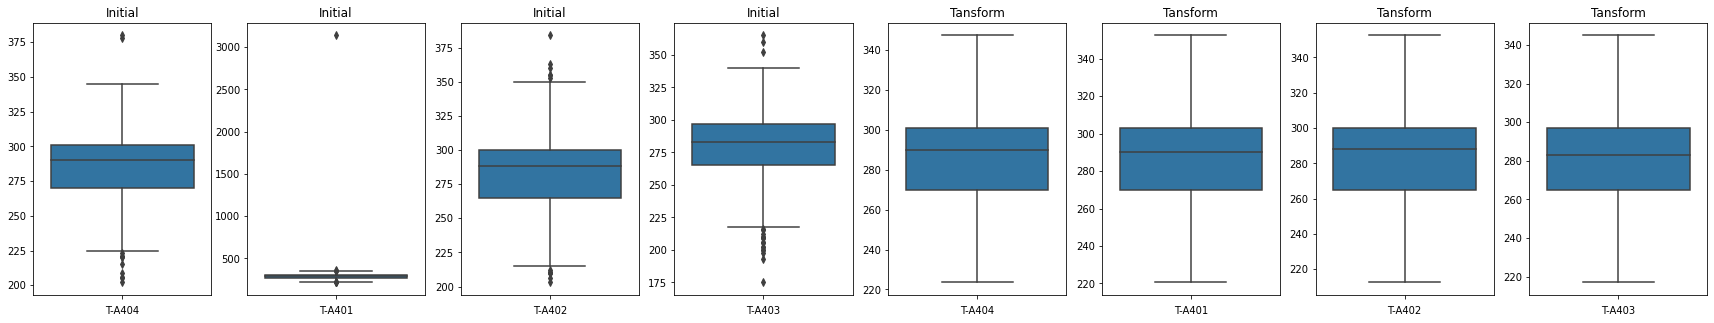

In [18]:
# 刪除P4_EC的outlier，0~7期的所有EC一起算
k   = 0
col = df4.columns[-8:]
fig, ax  = plt.subplots(1, 8, figsize = (30, 5))
category = df4["桃儲站油槽槽號"].unique()
for i in category:
    g  = df4.groupby("桃儲站油槽槽號")
    df = g.get_group(i).copy()
    EC = df[col].values.reshape(-1) #轉成一維
    EC = [j for j in EC if not np.isnan(j)] #刪除nan

    Q1   = np.quantile(EC, 0.25)
    Q3   = np.quantile(EC, 0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)

    df[col] = df[col].applymap(lambda X: max_ if X > max_ else X)
    df[col] = df[col].applymap(lambda X: min_ if X < min_ else X)
    df4.update(df)

    EC1 = df[col].values.reshape(-1)
    EC1 = [j for j in EC1 if not np.isnan(j)]

    sns.boxplot(y = EC, ax = ax[k]).set(xlabel = f"{i}", title = 'Initial')
    sns.boxplot(y = EC1, ax = ax[k+4]).set(xlabel = f"{i}", title = 'Tansform')
    k += 1

#### Feature generation

In [19]:
# 保留P4最後一個EC，之後P4與P2合併後，算P2期初的EC才能考慮到前一期P4還殘餘在油槽的油
EC_end = []
for i in range(len(df4)):
    EC_end.append(df4.iloc[i, -8:].dropna()[-1])
df4["EC_end"] = EC_end

In [20]:
# 從P2(P3)輸送到P3(P4)期間，每隔一段時間會檢測油管中的EC
# 取EC_0 ~ EC_7的min、max、mean、median作為sample的EC
def EC_transform(df):
    df["EC_mean"]   = df.iloc[:, -8:].mean(axis = 1).round(1)
    df["EC_median"] = df.iloc[:, -8:].median(axis = 1).round(1)
    df["EC_max"]    = df.iloc[:, -8:].max(axis = 1).round(1)
    df["EC_min"]    = df.iloc[:, -8:].min(axis = 1).round(1)

    EC_col = ['EC_0', 'EC_1', 'EC_2', 'EC_3', 'EC_4', 'EC_5', 'EC_6', 'EC_7']
    df     = df.drop(EC_col, axis = 1)

    return df
    
df2 = EC_transform(df2)
df4 = EC_transform(df4)

In [21]:
df2.head(3)

,輸油批號編號,麥寮廠油槽槽號,桃儲站油槽槽號,起泵時間,停泵時間,油量增加比例,start_vol,end_vol,壓力Kg/cm2,管線溫度℃,即時流速(KL/HR),EC_mean,EC_median,EC_max,EC_min
0,20201102-02-JFI-ML-TU,T-8513,T-A403,2020-11-02 21:19:00,2020-11-03 17:38:00,3.820285,1742.663,6657.470,2.460500,27.572727,223.029545,363.7,363.0,363.7,363.0
1,20201104-02-JFI-ML-TU,T-8513,T-A404,2020-11-04 20:56:00,2020-11-05 16:05:00,3.116438,1860.085,5796.840,2.664364,27.488636,220.152273,363.7,368.8,389.0,330.0
2,20201106-01-JFI-ML-TU,T-8513,T-A401,2020-11-06 02:18:00,2020-11-06 22:19:00,2.255220,1601.625,3612.017,3.067727,26.432143,191.356526,348.6,349.0,360.0,341.0


In [22]:
df4.head(3)

,輸油批號編號,桃儲站油槽槽號,桃園機場油槽槽號,起泵時間,停泵時間,start_vol,end_vol,油溫℃,管線壓力Kg/cm2,管線溫度℃,即時流速(KL/HR),input_管線壓力Kg/cm2,input_管線溫度℃,EC_end,EC_mean,EC_median,EC_max,EC_min
0,20201102-01-JFI-TU-TUA,T-A404,T-K701,2020-11-02 17:30:03,2020/11/03 11:11,6612.219,1856.369,25.483333,9.023833,29.029167,266.722222,3.631111,26.458333,270.0,269.0,270.0,270.0,269.0
1,20201104-01-JFI-TU-TUA,T-A401,T-K703,2020-11-04 17:04:27,2020/11/05 12:30,6626.279,3007.891,25.126316,8.881263,28.521053,262.989474,3.616316,26.222368,290.0,289.2,290.0,290.0,289.2
2,20201105-01-JFI-TU-TUA,T-A402,T-K702,2020-11-05 16:44:00,2020/11/06 10:17,6640.853,4418.211,26.300000,8.945857,28.830357,266.835714,3.532857,26.255357,352.5,314.6,314.6,352.5,314.6


#### Data Merge 

In [23]:
# mistake sample
df3.iloc[487, 4] = df3.iloc[487, 5][:10] # 停泵日期的年key錯
df4 = df4.drop([32]).reset_index(drop = True) # 包含許多nan
df4.iloc[268, 4] = df4.iloc[268, 3] #停汞時間 < 起汞時間，key錯，用起汞時間取代停汞時間

In [24]:
# object to datetime
df2["起泵時間"]    = pd.to_datetime(df2["起泵時間"])
df2["停泵時間"]    = pd.to_datetime(df2["停泵時間"])
df3["停泵日期"]    = pd.to_datetime(df3["停泵日期"])
df3["取樣時間"]    = pd.to_datetime(df3["取樣時間"])
df3["檢驗完成時間"] = pd.to_datetime(df3["檢驗完成時間"])
df4["起泵時間"]    = pd.to_datetime(df4["起泵時間"])
df4["停泵時間"]    = pd.to_datetime(df4["停泵時間"])

In [25]:
# 先停汞才取樣，若停汞日期 > 取樣時間，資料錯誤，以取樣停泵日期覆蓋取樣時間
error_index = df3.query("停泵日期 > 取樣時間").index
df3.iloc[error_index, 4] = df3.iloc[error_index, 5].apply(lambda X: X.date())

In [26]:
# 起始時間 > 結束時間超過1天，視為錯誤sample
detect2 = (df2["起泵時間"] - df2["停泵時間"]).apply(lambda X: X.days > 1)
detect3 = (df3["取樣時間"] - df3["檢驗完成時間"]).apply(lambda X: X.days > 1)
detect4 = (df4["起泵時間"] - df4["停泵時間"]).apply(lambda X: X.days > 1)

error2_index = df2[detect2].index
error3_index = df3[detect3].index
error4_index = df4[detect4].index

df2 = df2.drop(error2_index).reset_index(drop = True)
df3 = df3.drop(error3_index).reset_index(drop = True)
df4 = df4.drop(error4_index).reset_index(drop = True)

error2_index, error3_index, error4_index

(Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'))

In [27]:
# concat p3_last, p4_last, p2, p3, p4
df2.columns = ["p2_" + i for i in df2.columns]
df3.columns = ["p3_" + i for i in df3.columns]
df4.columns = ["p4_" + i for i in df4.columns]
col3_last   = [i+"_last" for i in df3.columns]
col4_last   = [i+"_last" for i in df4.columns]
col         = col3_last + col4_last + list(df2.columns) + list(df3.columns) + list(df4.columns)

df = pd.DataFrame(np.full([len(df2), len(col)], np.nan), columns = col)

for i in range(len(df2)):
    try: 
        p2     = df2.loc[i].to_list()
        group  = df2.loc[i, "p2_桃儲站油槽槽號"]
        start2 = df2.loc[i, "p2_起泵時間"]
        end2   = df2.loc[i, "p2_停泵時間"]

        p4_last     = df4.query("p4_桃儲站油槽槽號 == @group and p4_停泵時間 < @start2").sort_values("p4_停泵時間").iloc[-1].to_list()
        start4_last = p4_last[3] #p4_起泵時間

        p3_last = df3.query("p3_桃儲 == @group and p3_檢驗完成時間 < @start4_last").sort_values("p3_檢驗完成時間").iloc[-1].to_list()

        p3   = df3.query("p3_桃儲 == @group and p3_停泵日期 >= @end2.date()").sort_values("p3_取樣時間").iloc[0].to_list()
        end3 = p3[6] #p3_檢驗完成時間

        p4 = df4.query("p4_桃儲站油槽槽號 == @group and p4_起泵時間 > @end3").sort_values("p4_起泵時間").iloc[0].to_list()

        value      = p3_last + p4_last + p2 + p3 + p4
        df.iloc[i] = value
    except: #沒有p3_last、p4_last或p3、p4
        continue

In [28]:
# 刪除沒有p3_last、p4_last或p3、p4的sample
drop_index = df[df.isnull().all(axis = 1)].index
df         = df.drop(drop_index).reset_index(drop = True)
print(len(df))

368


In [29]:
# check date
df[[
    'p3_桃儲_last', 'p3_停泵日期_last', 'p3_取樣時間_last', 'p3_檢驗完成時間_last',
    'p4_桃儲站油槽槽號_last', 'p4_起泵時間_last', 'p4_停泵時間_last',
    'p2_桃儲站油槽槽號', 'p2_起泵時間', 'p2_停泵時間',
    'p3_桃儲', 'p3_停泵日期', 'p3_取樣時間', 'p3_檢驗完成時間',
    'p4_桃儲站油槽槽號', 'p4_起泵時間', 'p4_停泵時間'
    ]].head(3)

,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p4_桃儲站油槽槽號_last,p4_起泵時間_last,p4_停泵時間_last,p2_桃儲站油槽槽號,p2_起泵時間,p2_停泵時間,p3_桃儲,p3_停泵日期,p3_取樣時間,p3_檢驗完成時間,p4_桃儲站油槽槽號,p4_起泵時間,p4_停泵時間
0,T-A404,2020-10-29 00:00:00,2020-10-31 04:10:00,2020-10-31 05:00:00,T-A404,2020-11-02 17:30:03,2020-11-03 11:11:00,T-A404,2020-11-04 20:56:00,2020-11-05 16:05:00,T-A404,2020-11-05 00:00:00,2020-11-08 02:40:00,2020-11-08 03:40:00,T-A404,2020-11-09 16:40:02,2020-11-10 12:33:00
1,T-A401,2020-10-31 00:00:00,2020-11-02 04:10:00,2020-11-02 05:10:00,T-A401,2020-11-04 17:04:27,2020-11-05 12:30:00,T-A401,2020-11-06 02:18:00,2020-11-06 22:19:00,T-A401,2020-11-06 00:00:00,2020-11-10 03:10:00,2020-11-10 04:10:00,T-A401,2020-11-11 17:05:00,2020-11-12 11:50:00
2,T-A402,2020-11-01 00:00:00,2020-11-05 04:30:00,2020-11-05 05:30:00,T-A402,2020-11-05 16:44:00,2020-11-06 10:17:00,T-A402,2020-11-07 21:48:00,2020-11-08 15:51:00,T-A402,2020-11-08 00:00:00,2020-11-11 02:10:00,2020-11-12 03:00:00,T-A402,2020-11-12 19:26:04,2020-11-13 13:43:00


In [30]:
# drop ID
drop_col = [
       'p3_桃儲批號_last', 'p3_麥寮批號_last', 'p3_麥寮_last',
       'p4_輸油批號編號_last', 'p4_桃儲站油槽槽號_last', 'p4_桃園機場油槽槽號_last',
       'p2_輸油批號編號', 'p2_麥寮廠油槽槽號', 'p2_桃儲站油槽槽號',
       'p3_桃儲批號', 'p3_麥寮批號', 'p3_麥寮', 'p3_桃儲',
       'p4_輸油批號編號', 'p4_桃儲站油槽槽號', 'p4_桃園機場油槽槽號'
       ]

df = df.drop(drop_col, axis = 1)
df.head(3)

,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_起泵時間_last,p4_停泵時間_last,...,p4_管線壓力Kg/cm2,p4_管線溫度℃,p4_即時流速(KL/HR),p4_input_管線壓力Kg/cm2,p4_input_管線溫度℃,p4_EC_end,p4_EC_mean,p4_EC_median,p4_EC_max,p4_EC_min
0,T-A404,2020-10-29 00:00:00,2020-10-31 04:10:00,2020-10-31 05:00:00,38.0,285.0,26.0,789.90,2020-11-02 17:30:03,2020-11-03 11:11:00,...,8.875895,28.072368,265.884211,3.495263,26.163158,248.0,248.0,248.0,248.0,248.0
1,T-A401,2020-10-31 00:00:00,2020-11-02 04:10:00,2020-11-02 05:10:00,37.0,286.0,26.3,789.85,2020-11-04 17:04:27,2020-11-05 12:30:00,...,8.866278,28.043056,265.800000,3.475000,26.004167,250.0,266.6,250.0,266.6,250.0
2,T-A402,2020-11-01 00:00:00,2020-11-05 04:30:00,2020-11-05 05:30:00,78.0,270.0,26.3,789.90,2020-11-05 16:44:00,2020-11-06 10:17:00,...,8.862722,27.809722,266.488889,3.448333,25.866667,328.0,313.2,320.6,328.0,313.2


In [31]:
df.to_csv("data/data_merge.csv", index = False)

## Handle p2 data

In [32]:
df = pd.read_csv("data/data_merge.csv")
print(len(df))
df.head(3)

368


,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_起泵時間_last,p4_停泵時間_last,...,p4_管線壓力Kg/cm2,p4_管線溫度℃,p4_即時流速(KL/HR),p4_input_管線壓力Kg/cm2,p4_input_管線溫度℃,p4_EC_end,p4_EC_mean,p4_EC_median,p4_EC_max,p4_EC_min
0,T-A404,2020-10-29 00:00:00,2020-10-31 04:10:00,2020-10-31 05:00:00,38.0,285.0,26.0,789.90,2020-11-02 17:30:03,2020-11-03 11:11:00,...,8.875895,28.072368,265.884211,3.495263,26.163158,248.0,248.0,248.0,248.0,248.0
1,T-A401,2020-10-31 00:00:00,2020-11-02 04:10:00,2020-11-02 05:10:00,37.0,286.0,26.3,789.85,2020-11-04 17:04:27,2020-11-05 12:30:00,...,8.866278,28.043056,265.800000,3.475000,26.004167,250.0,266.6,250.0,266.6,250.0
2,T-A402,2020-11-01 00:00:00,2020-11-05 04:30:00,2020-11-05 05:30:00,78.0,270.0,26.3,789.90,2020-11-05 16:44:00,2020-11-06 10:17:00,...,8.862722,27.809722,266.488889,3.448333,25.866667,328.0,313.2,320.6,328.0,313.2


In [33]:
# p2 起始量<=結束量，為錯誤sample
error_index = df.query("p2_end_vol <= p2_start_vol").index
df = df.drop(error_index).reset_index(drop = True)
print(len(df))
df.head(3)

361


,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_起泵時間_last,p4_停泵時間_last,...,p4_管線壓力Kg/cm2,p4_管線溫度℃,p4_即時流速(KL/HR),p4_input_管線壓力Kg/cm2,p4_input_管線溫度℃,p4_EC_end,p4_EC_mean,p4_EC_median,p4_EC_max,p4_EC_min
0,T-A404,2020-10-29 00:00:00,2020-10-31 04:10:00,2020-10-31 05:00:00,38.0,285.0,26.0,789.90,2020-11-02 17:30:03,2020-11-03 11:11:00,...,8.875895,28.072368,265.884211,3.495263,26.163158,248.0,248.0,248.0,248.0,248.0
1,T-A401,2020-10-31 00:00:00,2020-11-02 04:10:00,2020-11-02 05:10:00,37.0,286.0,26.3,789.85,2020-11-04 17:04:27,2020-11-05 12:30:00,...,8.866278,28.043056,265.800000,3.475000,26.004167,250.0,266.6,250.0,266.6,250.0
2,T-A402,2020-11-01 00:00:00,2020-11-05 04:30:00,2020-11-05 05:30:00,78.0,270.0,26.3,789.90,2020-11-05 16:44:00,2020-11-06 10:17:00,...,8.862722,27.809722,266.488889,3.448333,25.866667,328.0,313.2,320.6,328.0,313.2


In [34]:
# p2可能分次輸送至p3，累積至一定量後，才從p3一次輸送至p4
# 對同一油槽且同一p3時間點下的p2做加權平均
drop_index = []
p2_col     = df.columns[24:34]
g          = df.groupby(["p3_桃儲_last", "p3_取樣時間"])
for i in g.size().index:
    df1 = g.get_group(i).iloc[:, 22:34] #同一油槽且同一p3時間點下的p2 data
    if len(df1) > 1:
        group_index = list(df1.index)

        # 同一油槽且同一p3時間點下，p2上次結束的量 > p2該次開始的量，表示中間少了一個p3的資料，此sample不可用(測量可能有誤差，範圍抓300)
        error_index  = []
        detect_error = (df1["p2_end_vol"].shift(1) - df1["p2_start_vol"]) > 300
        for j, k in zip(detect_error.index, detect_error.values):
            if k:
                error_index.append(last_index)
            last_index = j
        df1 = df1.drop(error_index)

        # 同一油槽且同一p3時間點下，p2的數據做加權平均
        diff_vol = df1["p2_end_vol"] - df1["p2_start_vol"]
        for j in p2_col[4:]: #'p2_壓力Kg/cm2', 'p2_管線溫度℃', 'p2_即時流速(KL/HR)', 'p2_EC_mean', 'p2_EC_median', 'p2_EC_max'
            df1[j] = sum(df1[j] * diff_vol) / sum(diff_vol)
        
        # 重新設定油量
        df1["p2_start_vol"]   = df1["p2_start_vol"].iloc[0]
        df1["p2_end_vol"]     = df1["p2_end_vol"].iloc[-1]
        df1["p2_油量增加比例"] = (df1["p2_end_vol"] - df1["p2_start_vol"]) / df1["p2_start_vol"]

        # 以df1加權的值覆蓋df原始的值
        df.iloc[df1.index[0], 22:34] = df1.iloc[0].values

        # 儲存要刪除的index
        group_index.remove(df1.index[0]) # 把要保留得index先砍掉，剩下存進drop_index統一刪除
        drop_index.extend(group_index)
        
df = df.drop(drop_index).reset_index(drop = True)
print(len(df))
df.head(3)

263


,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_起泵時間_last,p4_停泵時間_last,...,p4_管線壓力Kg/cm2,p4_管線溫度℃,p4_即時流速(KL/HR),p4_input_管線壓力Kg/cm2,p4_input_管線溫度℃,p4_EC_end,p4_EC_mean,p4_EC_median,p4_EC_max,p4_EC_min
0,T-A404,2020-10-29 00:00:00,2020-10-31 04:10:00,2020-10-31 05:00:00,38.0,285.0,26.0,789.90,2020-11-02 17:30:03,2020-11-03 11:11:00,...,8.875895,28.072368,265.884211,3.495263,26.163158,248.0,248.0,248.0,248.0,248.0
1,T-A401,2020-10-31 00:00:00,2020-11-02 04:10:00,2020-11-02 05:10:00,37.0,286.0,26.3,789.85,2020-11-04 17:04:27,2020-11-05 12:30:00,...,8.866278,28.043056,265.800000,3.475000,26.004167,250.0,266.6,250.0,266.6,250.0
2,T-A402,2020-11-01 00:00:00,2020-11-05 04:30:00,2020-11-05 05:30:00,78.0,270.0,26.3,789.90,2020-11-05 16:44:00,2020-11-06 10:17:00,...,8.862722,27.809722,266.488889,3.448333,25.866667,328.0,313.2,320.6,328.0,313.2


In [35]:
# object to datetime
time_col = [
    'p3_停泵日期_last', 'p3_取樣時間_last', 'p3_檢驗完成時間_last',
    'p4_起泵時間_last', 'p4_停泵時間_last',
    'p2_起泵時間', 'p2_停泵時間',
    'p3_停泵日期', 'p3_取樣時間', 'p3_檢驗完成時間',
    'p4_起泵時間', 'p4_停泵時間'
    ]
    
for i in time_col:
    df[i] = pd.to_datetime(df[i])

In [36]:
#時間相差太多天，可能中間有漏掉資料，視為錯誤sample
error_index   = []
detect_error1 = (df["p2_起泵時間"] - df["p3_檢驗完成時間_last"]).apply(lambda X: X.days)
detect_error2 = (df["p4_起泵時間"] - df["p2_停泵時間"]).apply(lambda X: X.days)

error_index.extend(detect_error1[detect_error1 > 30].index)
error_index.extend(detect_error2[detect_error2 > 30].index)

df = df.drop(set(error_index)).reset_index(drop = True)
print(len(df))
df.head(3)

258


,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_起泵時間_last,p4_停泵時間_last,...,p4_管線壓力Kg/cm2,p4_管線溫度℃,p4_即時流速(KL/HR),p4_input_管線壓力Kg/cm2,p4_input_管線溫度℃,p4_EC_end,p4_EC_mean,p4_EC_median,p4_EC_max,p4_EC_min
0,T-A404,2020-10-29,2020-10-31 04:10:00,2020-10-31 05:00:00,38.0,285.0,26.0,789.90,2020-11-02 17:30:03,2020-11-03 11:11:00,...,8.875895,28.072368,265.884211,3.495263,26.163158,248.0,248.0,248.0,248.0,248.0
1,T-A401,2020-10-31,2020-11-02 04:10:00,2020-11-02 05:10:00,37.0,286.0,26.3,789.85,2020-11-04 17:04:27,2020-11-05 12:30:00,...,8.866278,28.043056,265.800000,3.475000,26.004167,250.0,266.6,250.0,266.6,250.0
2,T-A402,2020-11-01,2020-11-05 04:30:00,2020-11-05 05:30:00,78.0,270.0,26.3,789.90,2020-11-05 16:44:00,2020-11-06 10:17:00,...,8.862722,27.809722,266.488889,3.448333,25.866667,328.0,313.2,320.6,328.0,313.2


In [37]:
df.to_csv("data/data_weight.csv", index = False)

## Predict

#### Load Data

In [38]:
df = pd.read_csv("data/data_weight.csv")
print(len(df))
df.head(3)

258


,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_起泵時間_last,p4_停泵時間_last,...,p4_管線壓力Kg/cm2,p4_管線溫度℃,p4_即時流速(KL/HR),p4_input_管線壓力Kg/cm2,p4_input_管線溫度℃,p4_EC_end,p4_EC_mean,p4_EC_median,p4_EC_max,p4_EC_min
0,T-A404,2020-10-29,2020-10-31 04:10:00,2020-10-31 05:00:00,38.0,285.0,26.0,789.90,2020-11-02 17:30:03,2020-11-03 11:11:00,...,8.875895,28.072368,265.884211,3.495263,26.163158,248.0,248.0,248.0,248.0,248.0
1,T-A401,2020-10-31,2020-11-02 04:10:00,2020-11-02 05:10:00,37.0,286.0,26.3,789.85,2020-11-04 17:04:27,2020-11-05 12:30:00,...,8.866278,28.043056,265.800000,3.475000,26.004167,250.0,266.6,250.0,266.6,250.0
2,T-A402,2020-11-01,2020-11-05 04:30:00,2020-11-05 05:30:00,78.0,270.0,26.3,789.90,2020-11-05 16:44:00,2020-11-06 10:17:00,...,8.862722,27.809722,266.488889,3.448333,25.866667,328.0,313.2,320.6,328.0,313.2


In [39]:
df[df.isnull().any(axis = 1)]

,p3_桃儲_last,p3_停泵日期_last,p3_取樣時間_last,p3_檢驗完成時間_last,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_起泵時間_last,p4_停泵時間_last,...,p4_管線壓力Kg/cm2,p4_管線溫度℃,p4_即時流速(KL/HR),p4_input_管線壓力Kg/cm2,p4_input_管線溫度℃,p4_EC_end,p4_EC_mean,p4_EC_median,p4_EC_max,p4_EC_min


#### Feature generate

In [40]:
# object to datetime
time_col = [
    'p3_停泵日期_last', 'p3_取樣時間_last', 'p3_檢驗完成時間_last',
    'p4_起泵時間_last', 'p4_停泵時間_last',
    'p2_起泵時間', 'p2_停泵時間',
    'p4_停泵時間'
    ]
    
for i in time_col:
    df[i] = pd.to_datetime(df[i])

In [41]:
time_ = df["p2_起泵時間"].apply(lambda X: X.date())
df = df.rename(index = time_).sort_index()

In [42]:
#各階段經過的時間(hours)
df["p3_p4_hour"] = (
    df
    .eval("p4_停泵時間_last - p3_停泵日期_last")
    .apply(lambda X: (X.days * 24) + (X.seconds / 3600))
    )
df["p4_p2_hour"] = (
    df
    .eval("p2_停泵時間 - p4_停泵時間_last")
    .apply(lambda X: (X.days * 24) + (X.seconds / 3600))
    )
df["p3_p2_hour"] = (
    df
    .eval("p2_停泵時間 - p3_停泵日期_last")
    .apply(lambda X: (X.days * 24) + (X.seconds / 3600))
    )
df["p2_p4_hour"] = (
    df
    .eval("p4_停泵時間 - p2_停泵時間")
    .apply(lambda X: (X.days * 24) + (X.seconds / 3600))
    )
    
df = df.drop(time_col, axis = 1)

In [43]:
# 實際預測時不會有p3, p4，以p3_last, p4_last, p2的資料來預測p4_EC
df = df.drop(df.columns[28:-5], axis = 1)

In [44]:
# 油槽中會有上一輪p4的剩餘油，需與該輪p2的油做加權平均
p2_vol = df.eval("p2_end_vol - p2_start_vol")
df["p2_EC_mix"] = df.eval("((p4_EC_end_last * p2_start_vol) + (p2_EC_mean * @p2_vol)) / p2_end_vol")
df = df.drop(['p4_EC_end_last', 'p4_start_vol_last', 'p4_end_vol_last','p2_start_vol', 'p2_end_vol'], axis = 1)

In [45]:
# 成長率
df["p3_p4_oil_temp"] = (df["p4_油溫℃_last"] - df["p3_溫度℃_last"]) / df["p3_溫度℃_last"]
df["p4_stress"]      = (df["p4_input_管線壓力Kg/cm2_last"] - df["p4_管線壓力Kg/cm2_last"]) / df["p4_管線壓力Kg/cm2_last"]
df["p4_oil_temp"]    = (df["p4_input_管線溫度℃_last"] - df["p4_管線溫度℃_last"]) / df["p4_管線溫度℃_last"]

#### 刪除衰退量變異大的sample

<AxesSubplot:>

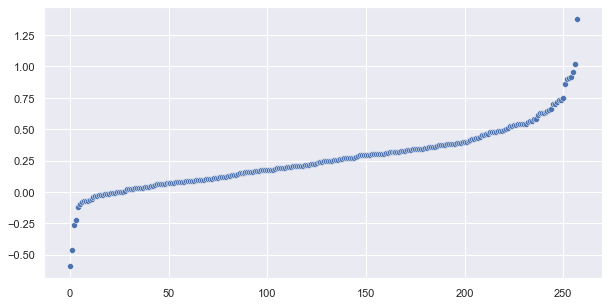

In [46]:
drop  = df.eval("(p2_EC_mix - p4_EC_min) / p2_p4_hour")
drop1 = sorted(drop)
sns.set(rc = {'figure.figsize': (10, 5)})
sns.scatterplot(x = list(range(len(drop1))), y = drop1)

In [47]:
df = df.query("(@drop < 0.80) & (@drop > -0.15)")
print(len(df))

247


<AxesSubplot:>

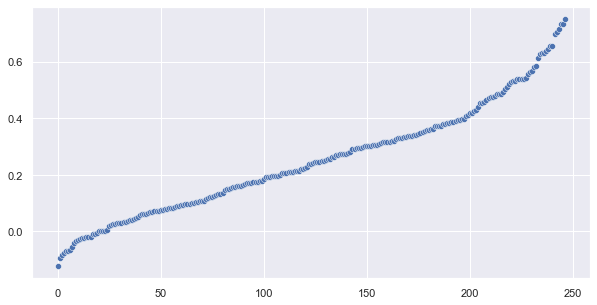

In [48]:
drop  = df.eval("(p2_EC_mix - p4_EC_min) / p2_p4_hour")
drop1 = sorted(drop)
sns.scatterplot(x = list(range(len(drop1))), y = drop1)

In [49]:
df = df.drop(['p2_p4_hour'], axis = 1) # 預測時不會知道p4的時間

#### Target轉換

In [50]:
# Target改為衰退，提升預測能力
df["EC_drop"] = df.eval("p2_EC_max - p4_EC_min")
# df["EC_drop"] = df["p4_EC_min"]
df = df.drop("p4_EC_min", axis = 1)

<AxesSubplot:>

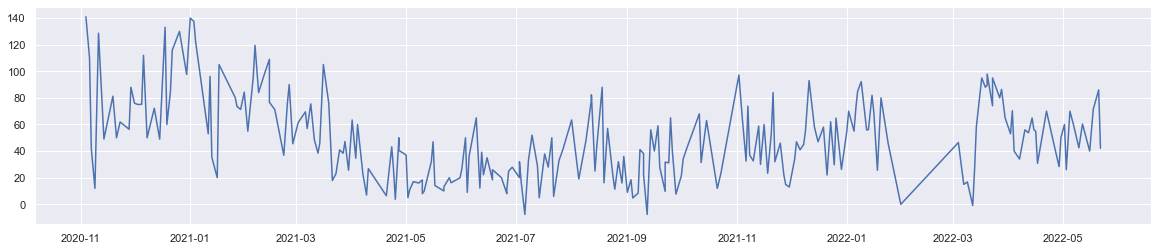

In [51]:
df["EC_drop"].plot(figsize=(20, 4))

#### Skew

In [52]:
skewness = df.iloc[:, 1:].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness

,Feature,Skew
0,p3_p4_hour,4.046882
1,p4_p2_hour,3.348605
2,p3_p2_hour,2.869491
3,p4_oil_temp,1.204951
4,p2_EC_mean,0.940477
5,p2_EC_median,0.893828
6,p2_EC_max,0.874037
7,p3_靜置H_last,0.868766
29,p2_即時流速(KL/HR),-0.871018


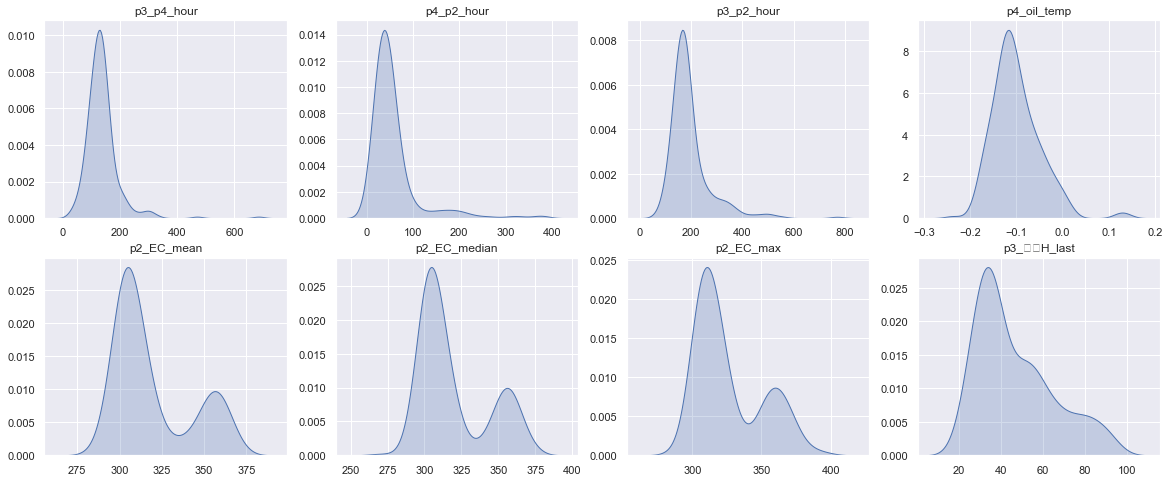

In [53]:
a, b = 2, 4
k = 0
fig, ax = plt.subplots(a, b, figsize = (20, 8))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = df.reset_index(drop = True), x = skewness["Feature"].iloc[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skewness["Feature"].iloc[k])
        k += 1

In [54]:
pt = PowerTransformer(method = 'yeo-johnson')
df[skewness["Feature"]] = pt.fit_transform(df[skewness["Feature"]])

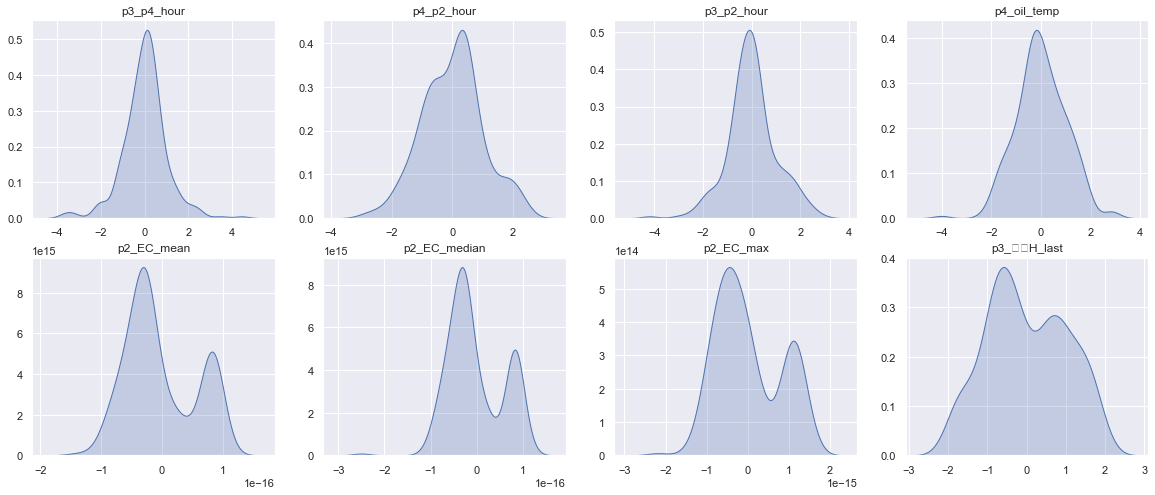

In [55]:
a, b = 2, 4
k = 0
fig, ax = plt.subplots(a, b, figsize = (20, 8))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = df.reset_index(drop = True), x = skewness["Feature"].iloc[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skewness["Feature"].iloc[k])
        k += 1

#### Feature scaling

In [56]:
df = df.drop("p3_桃儲_last", axis = 1)

In [57]:
scaler = StandardScaler() 
X_train_scaled  = scaler.fit_transform(df.iloc[:, :-1])
df.iloc[:, :-1] = X_train_scaled
df.head(3)

,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_油溫℃_last,p4_管線壓力Kg/cm2_last,p4_管線溫度℃_last,p4_即時流速(KL/HR)_last,p4_input_管線壓力Kg/cm2_last,p4_input_管線溫度℃_last,...,p2_EC_max,p2_EC_min,p3_p4_hour,p4_p2_hour,p3_p2_hour,p2_EC_mix,p3_p4_oil_temp,p4_stress,p4_oil_temp,EC_drop
2020-11-04,-0.287589,0.563457,0.377326,1.549686,0.309516,1.503936,0.281154,1.600961,0.184765,0.467177,...,1.973034,0.735009,0.085395,0.446134,0.169463,1.194083,-0.058296,-1.184490,0.381726,141.0
2020-11-06,-0.366432,0.602333,0.460194,1.522459,0.219929,1.135462,0.154713,1.161434,0.100292,0.392085,...,1.405742,1.188043,0.112893,-0.347490,-0.171743,0.653299,-0.590868,-0.951240,0.534632,110.0
2020-11-07,1.483780,-0.019674,0.460194,1.549686,0.514442,1.302406,0.231681,1.614324,-0.376209,0.402583,...,1.263919,1.669907,0.066431,0.465854,0.165371,2.126889,0.369219,-1.548245,0.366879,41.8


#### Modeling

In [58]:
df1 = df.copy()
print(len(df1))
df1.head(2)

247


,p3_靜置H_last,p3_導電度_last,p3_溫度℃_last,p3_密度ｋｇ／ｍ３_last,p4_油溫℃_last,p4_管線壓力Kg/cm2_last,p4_管線溫度℃_last,p4_即時流速(KL/HR)_last,p4_input_管線壓力Kg/cm2_last,p4_input_管線溫度℃_last,...,p2_EC_max,p2_EC_min,p3_p4_hour,p4_p2_hour,p3_p2_hour,p2_EC_mix,p3_p4_oil_temp,p4_stress,p4_oil_temp,EC_drop
2020-11-04,-0.287589,0.563457,0.377326,1.549686,0.309516,1.503936,0.281154,1.600961,0.184765,0.467177,...,1.973034,0.735009,0.085395,0.446134,0.169463,1.194083,-0.058296,-1.18449,0.381726,141.0
2020-11-06,-0.366432,0.602333,0.460194,1.522459,0.219929,1.135462,0.154713,1.161434,0.100292,0.392085,...,1.405742,1.188043,0.112893,-0.347490,-0.171743,0.653299,-0.590868,-0.95124,0.534632,110.0


In [59]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.2, shuffle = True, random_state = 777)
train = train.reset_index(drop = True)
test  = test.reset_index(drop = True)
train.shape, test.shape

((197, 30), (50, 30))

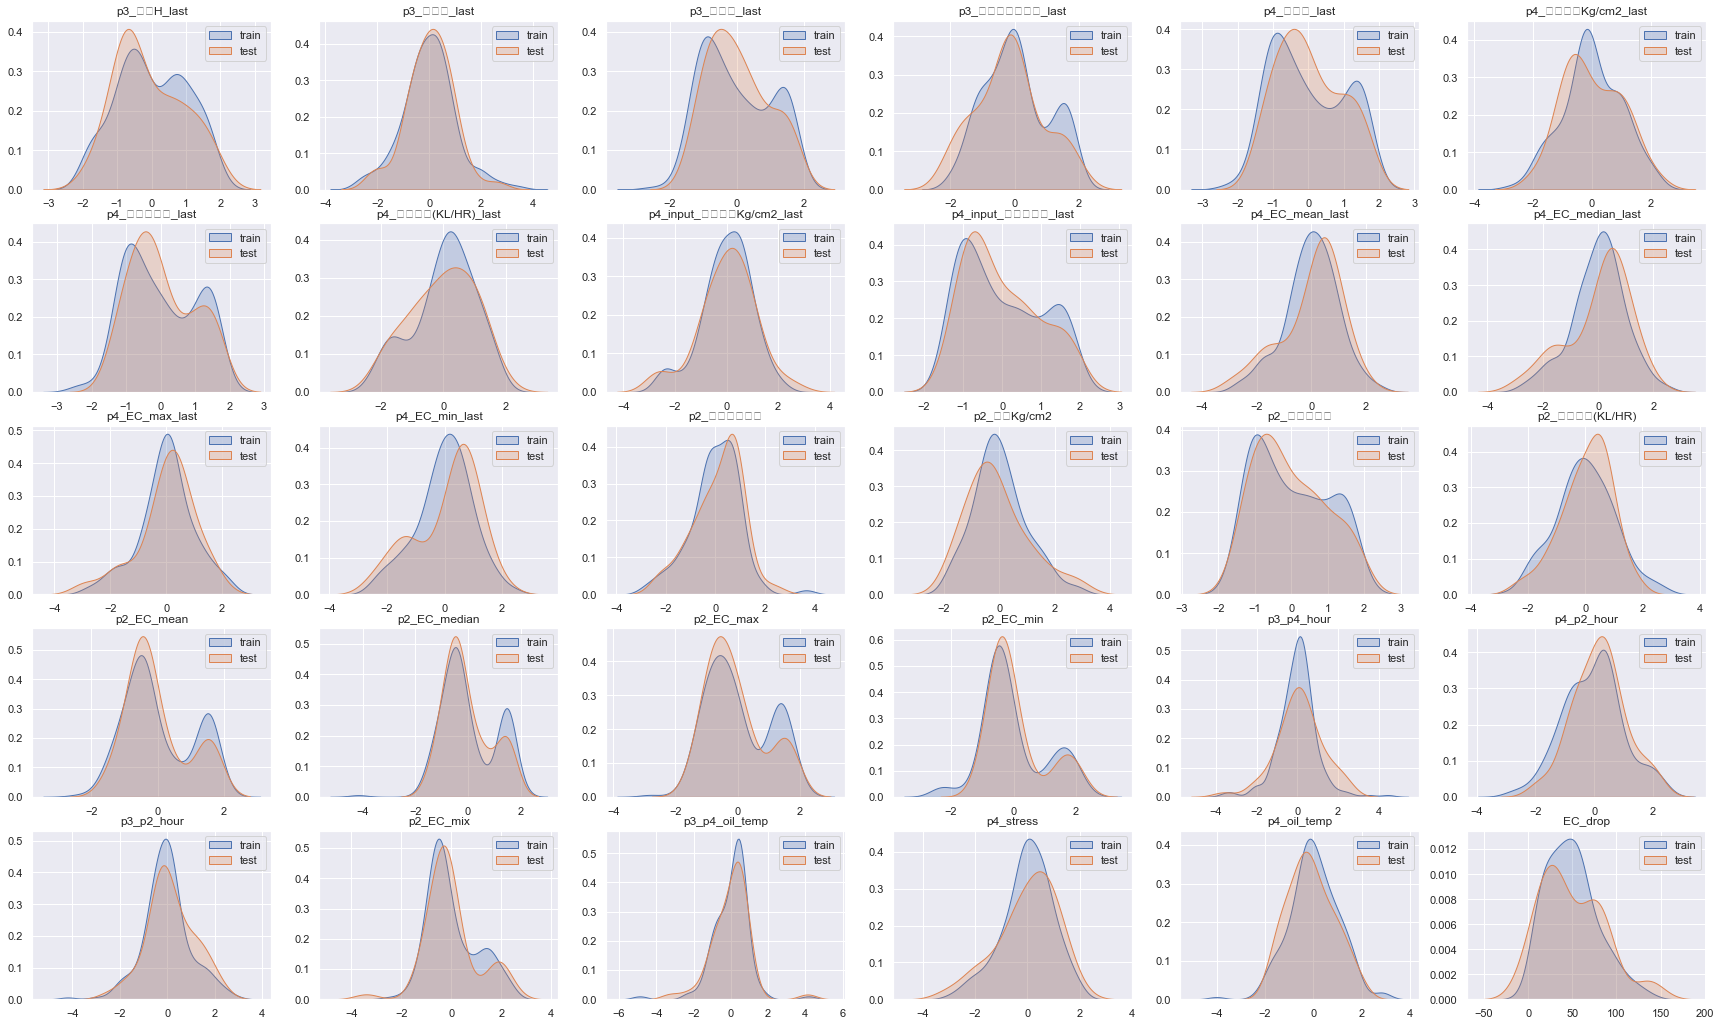

In [60]:
a, b = 5, 6
fig, ax = plt.subplots(a, b, figsize = (30, 18))
k = 0
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = train, x = train.columns[k], shade=True, ax = ax[i, j], label="train")
        sns.kdeplot(data = test, x = train.columns[k], shade=True, ax = ax[i, j], label="test")
        ax[i, j].set(ylabel = None, xlabel = None, title = train.columns[k])
        ax[i, j].legend()
        k += 1
plt.show()

In [61]:
X_train = train.drop("EC_drop", axis = 1)
X_test  = test.drop("EC_drop", axis = 1)
y_train = train["EC_drop"]
y_test  = test["EC_drop"]

In [62]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

random_state = 99#None
models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization)": Ridge(),
    " Linear Regression (L1 Regularization)": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(random_state = random_state),
    "                     Gradient Boosting": GradientBoostingRegressor(random_state = random_state),
    "                               XGBoost": XGBRegressor(random_state = random_state),
    "                              LightGBM": LGBMRegressor(random_state = random_state),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    # print(name + " trained.")

In [63]:
score = []
for model in models.values():
    train_mse  = mean_squared_error(y_train, model.predict(X_train)).round(2)
    test_mse   = mean_squared_error(y_test, model.predict(X_test)).round(2)
    train_rmse =  (train_mse ** (1/2)).round(2)
    test_rmse  =  (test_mse ** (1/2)).round(2)
    train_r2   = model.score(X_train, y_train).round(2)
    test_r2    = model.score(X_test, y_test).round(2)

    # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
    # cv_scores = cross_val_score(model, X_train, y_train, cv = cv)
    # cv_score = cv_scores.mean().round(2)

    score.append([train_mse, test_mse, train_rmse, test_rmse, train_r2, test_r2])#, cv_score

index  = [i.lstrip() for i in models.keys()]
column = ["MSE_train", "MSE_test", "RMSE_train", "RMSE_test", "R2_train", "R2_test"]#, "R2_cv"
score  = pd.DataFrame(score, index = index, columns = column)
score

,MSE_train,MSE_test,RMSE_train,RMSE_test,R2_train,R2_test
Linear Regression,413.46,751.28,20.33,27.41,0.52,0.41
Linear Regression (L2 Regularization),425.77,706.83,20.63,26.59,0.50,0.44
Linear Regression (L1 Regularization),503.37,677.16,22.44,26.02,0.41,0.47
K-Nearest Neighbors,391.55,658.26,19.79,25.66,0.54,0.48
Neural Network,913.73,1168.27,30.23,34.18,-0.06,0.08
Support Vector Machine (Linear Kernel),554.05,827.88,23.54,28.77,0.35,0.35
Support Vector Machine (RBF Kernel),701.42,1054.67,26.48,32.48,0.18,0.17
Decision Tree,0.00,746.44,0.00,27.32,1.00,0.41
Random Forest,77.68,536.72,8.81,23.17,0.91,0.58
Gradient Boosting,30.23,451.29,5.50,21.24,0.96,0.64


In [64]:
model = models["                     Gradient Boosting"]
feature_imp = pd.DataFrame(zip(X_test.columns, model.feature_importances_), columns = ["Feature", "Value"])
feature_imp = feature_imp.sort_values(by = "Value", ascending = False)
feature_imp

,Feature,Value
20,p2_EC_max,0.299180
11,p4_EC_median_last,0.083470
3,p3_密度ｋｇ／ｍ３_last,0.068613
7,p4_即時流速(KL/HR)_last,0.063044
0,p3_靜置H_last,0.050410
5,p4_管線壓力Kg/cm2_last,0.047203
12,p4_EC_max_last,0.039131
9,p4_input_管線溫度℃_last,0.034821
17,p2_即時流速(KL/HR),0.031682
14,p2_油量增加比例,0.028987


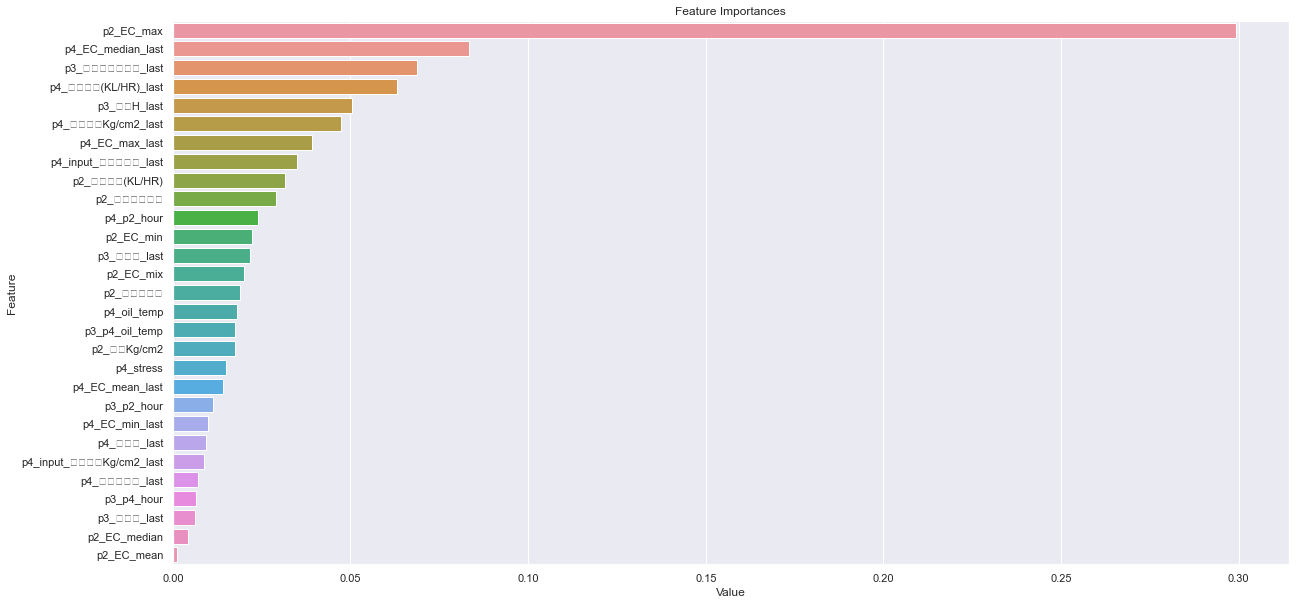

In [65]:
plt.figure(figsize=(20, 10))
sns.barplot(x = "Value", y = "Feature", data = feature_imp)
plt.title("Feature Importances")
plt.show()

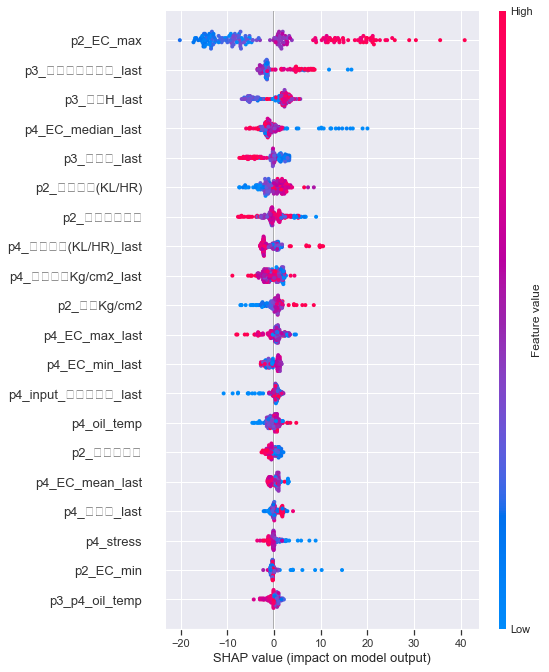

In [66]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)